Digital DNA Model account behaviour by defining the following alphabet, of cardinality N = 3,

𝐵3𝑡𝑦𝑝𝑒={𝐴,𝐶,𝑇} 
A  ←  tweet,

C  ←  reply,

T  ←  retweet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [2]:
import sys
import time
import zlib

In [3]:
from sklearn import utils
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix

In [4]:
# load dataset
data_path = '/Users/anne/Desktop/capstone/Twibot-20/'

# load all twitter ids
train_ds = pd.read_json(data_path+'train.json')
validate_ds = pd.read_json(data_path+'dev.json')
test_ds = pd.read_json(data_path+'test.json')

ds = pd.concat([train_ds,validate_ds,test_ds],ignore_index=True)
ds.describe
print(ds[ds.label==1])

                        ID                                            profile  \
1      1297437077403885568  {'id': '1297437077403885568 ', 'id_str': '1297...   
4               1659167666  {'id': '1659167666 ', 'id_str': '1659167666 ',...   
8      1297609266623217664  {'id': '1297609266623217664 ', 'id_str': '1297...   
13               849880970  {'id': '849880970 ', 'id_str': '849880970 ', '...   
16                39555442  {'id': '39555442 ', 'id_str': '39555442 ', 'na...   
...                    ...                                                ...   
11821            452754350  {'id': '452754350 ', 'id_str': '452754350 ', '...   
11822   850435801687183360  {'id': '850435801687183362 ', 'id_str': '85043...   
11823           2188795745  {'id': '2188795745 ', 'id_str': '2188795745 ',...   
11824            940687680  {'id': '940687680 ', 'id_str': '940687680 ', '...   
11825           3385331674  {'id': '3385331674 ', 'id_str': '3385331674 ',...   

                           

In [5]:
# generate a digit DNA for each account 
def create_dna_from_tweets(tweets):
    dna = ''
    if not tweets:
        return dna
    for index, row in enumerate(tweets):
        # retweet
        if row.startswith('RT'):
            dna += 'T'
        # reply
        elif row.startswith('@'):
            dna += 'C'
        # tweet
        else:
            dna += 'A'
    return dna

In [6]:
def compress_dna_df(dna):
    '''Return a dataframe with compression facts for a series of dna.'''

    # Convert DNA in string object to bytes object.
    dna_bytes = dna.apply(lambda s: s.encode('utf-8'))

    # Run compression on each DNA string in the sample.
    dna_compressed = dna_bytes.apply(lambda b: zlib.compress(b))

    # Create dataframe with compression facts.
    dna_df = pd.DataFrame({'original_dna_size': dna_bytes.apply(sys.getsizeof), 
                           'compressed_dna_size': dna_compressed.apply(sys.getsizeof)})
    
    dna_df['compression_ratio'] = dna_df['original_dna_size'] / dna_df['compressed_dna_size']
    
    return dna_df

In [7]:
# create digital DNA for all datasets
ds['dna'] = ds.apply(lambda x: create_dna_from_tweets(x['tweet']),axis=1)
dna_compress = compress_dna_df(ds['dna'])
ds = pd.concat([ds['dna'],ds['tweet'],dna_compress,ds['label']],axis=1)


In [8]:
ds.describe

<bound method NDFrame.describe of                                                      dna  \
0      TAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAATATCTCAAAC...   
1                                                          
2      TATTTAATATAATTTTATATTTTTATTTAATTTAAAAATTATTATT...   
3      AAATTATTAATAATTATATTAAATTTAAATAATAAAATAATAATAT...   
4      TTTTTTTTATTTAAAAAAAAAAATTTAATTAAAATTATTTTTTTTA...   
...                                                  ...   
11821  ACATATTTAAAATTATATAAAAAACATAAAAAAAAATAAAAAAATA...   
11822  TCCACCACCCACACCCCTATTCACCACATTCAACCCCCACCTCCAC...   
11823  TTCTTCTCTTTTTCTTCATTCCCTCCTCCCCCCCTCCCCCCCCCCC...   
11824  TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT...   
11825  TTTCTTACCTACTAATTCCCTCCCTATTTTCTTACAATATTTTCTC...   

                                                   tweet  original_dna_size  \
0      [RT @CarnivalCruise: 🎉 Are you ready to see wh...                233   
1                                                   None                 33   
2      [

In [9]:
import re
def count_matches(text, pattern):
    return len(re.findall(pattern, text))
# add extra features - number of retweets, number of emojis, number of URLs, number of mentions
def count_retweet(tweets):
    retweet = 0
    if tweets:
        for t in tweets:
            if t[0:2] == 'RT':
                retweet +=1
    return retweet
def count_emojis(tweets):
    emojis = 0
    if tweets:
        for t in tweets:
            emojis += count_matches(t,'(\\u00a9|\\u00ae|[\\u2000-\\u3300]|\\ud83c[\\ud000-\\udfff]|\\ud83d[\\ud000-\\udfff]|\\ud83e[\\ud000-\\udfff])')
    return emojis

def count_URLs(tweets):
    urls = 0
    if tweets:
         for t in tweets:
            urls += count_matches(t,'https://t\.co')
    return urls
        
def add_extra_features(tweets):
    #count retweets
    retweets = tweets.apply(lambda t: count_retweet(t))
    
    #count emojis 
    emojis = tweets.apply(lambda t:count_emojis(t))
    
    #count urls
    urls = tweets.apply(lambda t:count_URLs(t))
    
    extra_feature_df = pd.DataFrame({'number_of_retweets':retweets, 'number_of_emojis':emojis, 'number_of_urls':urls})
    return extra_feature_df
        
    

In [10]:
# add extra_features to all ds
ef_ds = add_extra_features(ds['tweet'])
ds = pd.concat([ef_ds,ds],axis=1)


In [11]:
ds.describe

<bound method NDFrame.describe of        number_of_retweets  number_of_emojis  number_of_urls  \
0                      33               122             206   
1                       0                 0               0   
2                     130               196              93   
3                      76                85             172   
4                      46                75              57   
...                   ...               ...             ...   
11821                  40                51             167   
11822                  30                30             108   
11823                  94               146              68   
11824                 133                96              36   
11825                  97                49              65   

                                                     dna  \
0      TAAAAAAAAAAAAAAAAAACAAAAAAAAAAAAAAAATATCTCAAAC...   
1                                                          
2      TATTTAATATAATTTTATATTT

In [12]:
# Filter genuine accounts and bot accounts to compute statistics for each group.
g = ds['label'] == 0
b = ds['label'] == 1

In [13]:
compression_stats = pd.DataFrame({'Mean Length': [ds['dna'].apply(len).mean(), 
                                                  ds[g]['dna'].apply(len).mean(), 
                                                  ds[b]['dna'].apply(len).mean()],
                                  'SD Length': [ds['dna'].apply(len).std(), 
                                                ds[g]['dna'].apply(len).std(), 
                                                ds[b]['dna'].apply(len).std()],
                                  'Mean Uncompressed Size': [ds['original_dna_size'].mean(), 
                                                             ds[g]['original_dna_size'].mean(), 
                                                             ds[b]['original_dna_size'].mean()],
                                  'SD Uncompressed Size': [ds['original_dna_size'].std(), 
                                                            ds[g]['original_dna_size'].std(), 
                                                           ds[b]['original_dna_size'].std()],
                                  'Mean Compressed Size': [ds['compressed_dna_size'].mean(), 
                                                           ds[g]['compressed_dna_size'].mean(), 
                                                           ds[b]['compressed_dna_size'].mean()],
                                  'SD Compressed Size': [ds['compressed_dna_size'].std(), 
                                                         ds[g]['compressed_dna_size'].std(), 
                                                         ds[b]['compressed_dna_size'].std()],
                                  'Mean Compressio Ratio': [ds['compression_ratio'].mean(), 
                                                            ds[g]['compression_ratio'].mean(), 
                                                            ds[b]['compression_ratio'].mean()],
                                  'SD Compressio Ratio': [ds['compression_ratio'].std(), 
                                                          ds[g]['compression_ratio'].std(), 
                                                          ds[b]['compression_ratio'].std()]},
                                 index=['All', 'Genuine', 'Bot']).round(decimals=3)

#### Compression statistics visualization

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:806: UserWarning: You passed a edgecolor/edgecolors ('white') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  func(*plot_args, **plot_kwargs)


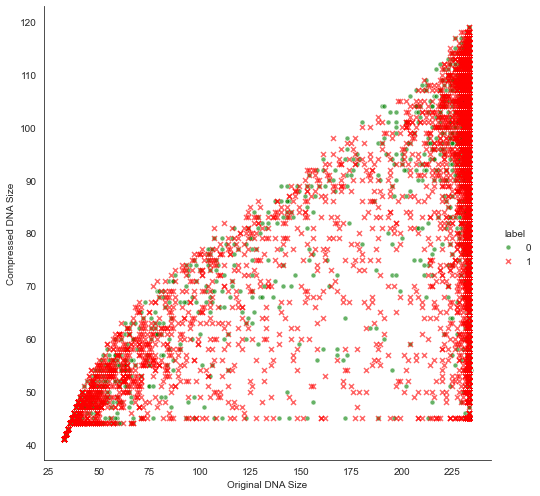

In [14]:
##### Plot of Uncompressed DNA Size vs. Compressed DNA Size.
sns.set_style("white")

pal = {
    0: 'green',
    1: 'red'
}

g = sns.FacetGrid(ds, hue='label', palette=pal, size=7, hue_kws=dict(marker=["o", "x"]))
g.map(plt.scatter, "original_dna_size", "compressed_dna_size", s=25, alpha=0.6, edgecolor="white")
g.add_legend()
g.set_axis_labels('Original DNA Size', 'Compressed DNA Size')

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


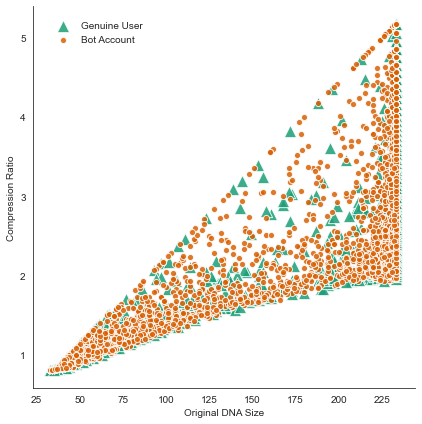

In [15]:
##### Plot of Uncompressed DNA Size vs. Compression ratio
sns.set_style("white")

pal = {
    0: sns.color_palette('Dark2')[0],
    1: sns.color_palette('Dark2')[1]
}

g = sns.FacetGrid(ds, hue='label', palette=pal, height=6, hue_kws=dict(marker=["^", "."]))
g.map(plt.scatter, "original_dna_size", "compression_ratio", s=150, alpha=0.85, edgecolor="white")
g.add_legend(title='',bbox_to_anchor=(0.3, 0.95), loc=1, borderaxespad=0., labels=['Genuine User', 'Bot Account'])
g.set_axis_labels('Original DNA Size', 'Compression Ratio')
g.savefig('twibot_scatter.svg')

/usr/local/lib/python3.9/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


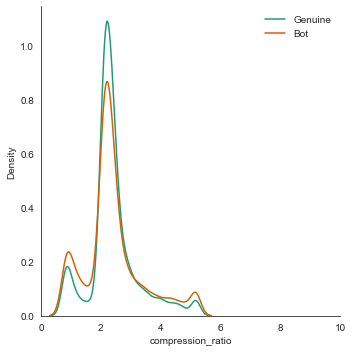

In [16]:
g = sns.FacetGrid(ds, hue='label', palette=pal, size=5)
g.set(xlim=(0, 10))
g.map(sns.kdeplot, 'compression_ratio')
plt.legend(loc='upper right', frameon=False, title='', labels=['Genuine','Bot'])
g.savefig('twibot_KDE.svg')

#### Train, predict and evaluate

In [17]:
def evaluate(y_test, predictions):
    '''Return a dataframe with accuracy, precision, recall and f1 scores for predictions.'''
    
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    specificity = tn / (tn+fp)
    
    results = [
        {
            'Metric': 'Accuracy',
            'Score': accuracy_score(y_test, predictions)
        },
        {
            'Metric': 'Precision',
            'Score': precision_score(y_test, predictions)
        },
        {
            'Metric': 'Recall',
            'Score': recall_score(y_test, predictions)
        },
        {
            'Metric': 'F1 Score',
            'Score': f1_score(y_test, predictions)
        },
        {
            'Metric': 'MCC',
            'Score': matthews_corrcoef(y_test, predictions)
        },
        {
            'Metric': 'Specificity',
            'Score': specificity
        },
    ]

    return pd.DataFrame(results)

In [26]:
def train_predict_evaluate(classifier, dna, features, test_size=0.3):
    '''Train a Logistic Regression model with given features
    using default parameters on a random sample of data.'''

    # Randomly shuffle the dna dataframe.
    dna = utils.shuffle(dna)

    # Features and labels.
    X = dna[features]
    y = dna.loc[:, 'label']

    # Split the dataset for training and testing using Logistic Regression.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Train the classifier.
    start_train = time.time()
    classifier.fit(X_train, y_train)
    end_train = time.time()

    # Make predictions on the test set.
    start_test = time.time()
    predictions = classifier.predict(X_test)
    end_test = time.time()

    # Evaluation on the test set.
    results = evaluate(y_test, predictions)

    return results

In [27]:
rf_classifier = RandomForestClassifier(bootstrap=True,max_depth=5)
train_predict_evaluate(rf_classifier,ds,['original_dna_size', 'compressed_dna_size'])

,Metric,Score
0,Accuracy,0.604848
1,Precision,0.653272
2,Recall,0.634952
3,F1 Score,0.643982
4,MCC,0.200334
5,Specificity,0.566086


In [30]:
train_predict_evaluate(rf_classifier,ds,['original_dna_size', 'compression_ratio'])

,Metric,Score
0,Accuracy,0.608230
1,Precision,0.674481
2,Recall,0.619071
3,F1 Score,0.645589
4,MCC,0.210411
5,Specificity,0.593480


In [21]:
train_predict_evaluate(rf_classifier,ds,['original_dna_size', 'compression_ratio','number_of_retweets',
                                                    'number_of_urls', 'number_of_emojis'])

,Metric,Score
0,Accuracy,0.638833
1,Precision,0.653143
2,Recall,0.746910
3,F1 Score,0.696886
4,MCC,0.258613
5,Specificity,0.503570


In [22]:

gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0)


In [23]:
train_predict_evaluate(gb_classifier,ds,['original_dna_size', 'compressed_dna_size'])

,Metric,Score
0,Accuracy,0.593489
1,Precision,0.626786
2,Recall,0.666540
3,F1 Score,0.646052
4,MCC,0.170145
5,Specificity,0.501788


In [24]:
train_predict_evaluate(gb_classifier,ds,['original_dna_size', 'compression_ratio'])

,Metric,Score
0,Accuracy,0.589155
1,Precision,0.619064
2,Recall,0.682603
3,F1 Score,0.649283
4,MCC,0.157360
5,Specificity,0.471599


In [25]:
train_predict_evaluate(gb_classifier,ds,['original_dna_size', 'compression_ratio','number_of_retweets',
                                                    'number_of_urls', 'number_of_emojis'])

,Metric,Score
0,Accuracy,0.630694
1,Precision,0.650137
2,Recall,0.722540
3,F1 Score,0.684429
4,MCC,0.244274
5,Specificity,0.516481
